In [2]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c anaconda beautifulsoup4 --yes

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
!conda install -c conda-forge geocoder --yes 
import geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-base-1.15.4          |   py36h81de0dd_0         4.2 MB  anaconda
    beautifulsoup4-4.8.2       |           py36_0         161 KB  anaconda
    numpy-1.15.4               |   py36h1d66e8a_0          35 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    soupsieve-1.9.5            |           py36_0          61 KB  anaconda
    mkl_fft-1.0.6              |   py36h7dd41cf_0         150 KB  anaconda
    certifi-2019.11.28         |           py36_0         156 KB  an

<b>1. Build the dataframe for the Toronto Neighbourhoods using BeautifulSoup.</b>

In [3]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [4]:
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
df.head(10)

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Not assigned


<b>1.1 Clean up the dataframe for the Toronto neighbourhood.</b>

In [5]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Queen's Park,Not assigned
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [6]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df.loc[df['Neighbourhood']=='Not assigned', ['Neighbourhood']] = 'Queen\'s Park'
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Queen's Park,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


<b>2. Build the dataframe for Toronto neighbourhood population</b>

In [7]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
skip_table = 1

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find_all('table')[skip_table]
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [39]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)

# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese


In [9]:
# get the data size
df1.shape
df1.shape

(174, 9)

In [41]:
df1['Latitude'] = ''
df1['Longitude'] = ''
df1
# dummy values in case that geocoder is not working for the day
#df1['Latitude'] = 43.638093
#df1['Longitude'] = -79.4665843

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,,
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,,
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian,,
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,,
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian,,
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin,,
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese,,


<b>3. Find out the latitude and longitude for each neighbourhood.</b>

In [11]:
# loop through the postal code to find out the latitude and longitude
geoloc = pd.read_csv("Geospatial_Coordinates.csv")
geoloc.rename(columns={"Postal Code": "PostalCode"},inplace=True)
df = df.join(geoloc.set_index('PostalCode'), on='PostalCode')
df.reset_index(drop=True,inplace=True)
df.head()


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


In [52]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="courseraCapstone3")
df1['fullAdresse'] = df1['Neighbourhood'].map(str) + ', Toronto, Ontario' 
for index, data in df1.iterrows():
    lat_lng_coords = None
    time.sleep(1)
    location = geolocator.geocode(data['fullAdresse'] )
    lat_lng_coords = location
    if lat_lng_coords is None :
        print ('None')
    else :
        df1.at[index, 'Latitude'] = lat_lng_coords.latitude
        df1.at[index, 'Longitude'] = lat_lng_coords.longitude
        

None
None
None
None
None
None
None
None
None
None


# loop through the postal code to find out the latitude and longitude
for index, data in df1.iterrows():
    lat_lng_coords = None
    #print ('Now at PostalCode:', data['PostalCode'])
    #print ('Now at Neighbourhood:', data['Neighbourhood'])
    while(lat_lng_coords is None):
        #g = geocoder.google('{}, Toronto, Ontario'.format(data['PostalCode']))
        g = geocoder.google('{}, Toronto, Ontario'.format(data['Neighbourhood']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('Neighbourhood:', data['Neighbourhood'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])
    
# loop through the postal code to find out the latitude and longitude
for index, data in df.iterrows():
    lat_lng_coords = None
    print ('Now at PostalCode:', data['PostalCode'])
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(data['PostalCode']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('PostalCode:', data['PostalCode'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])

<b>3.1 Print out the updated dataframe.</b>

In [54]:
# Get names of indexes for which column Latitude is null
copieOFdf1 = df1 #copie of the df1 to avoid requesting geocode
indexNames = df1[ df1['Latitude'] == '' ].index
# Delete these row indexes from dataFrame and the fullAdresse Column
df1.drop(indexNames , inplace=True)
df1.drop(['fullAdresse'], axis=1,inplace=True)
df1.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.7854,-79.2785
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,43.6017,-79.5452
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,43.6508,-79.4043
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,43.7114,-79.5534
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,43.7062,-79.4835


<b>3.2 Double check on the data quality of the dataframe.</b>

In [55]:
# double check on the dataframe
print('The dataframe has {} neighborhoods.'.format(
        len(df1['Neighbourhood'].unique()),
        df1.shape[0]
    )
)

The dataframe has 164 neighborhoods.


<b>3.3 Add the population weightage for each neighbourhood.</b>

In [56]:
total_population = df1['Population'].sum()
#print (total_population)

# the higher populated neighbourhood will have the higher score
df1['Population Score'] = df1['Population']/total_population*100

# sort the dataframe based on the descending population score
df1 = df1.sort_values('Population Score', ascending=False)
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588
170,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7598,-79.2253,2.110072
50,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7573,-79.5177,2.088147
86,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.799,-79.306,1.995013
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.7854,-79.2785,1.939115
98,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.928110
168,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7615,-79.4109,1.876779
44,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.7493,-79.4622,1.592678
108,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.7939,-79.4257,1.568014
139,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.6312,-79.4857,1.522338


<b>3.4 Display the top 10 populated neighbourhood in the barchart.</b>

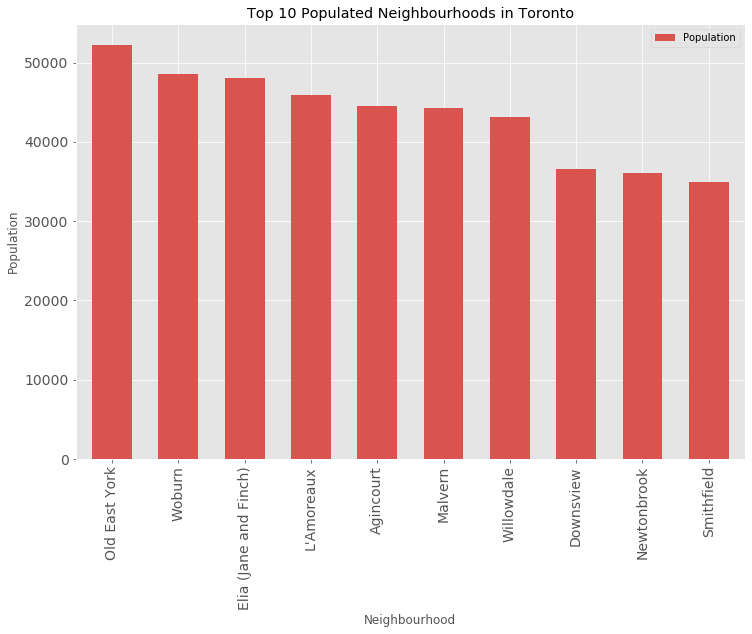

In [57]:
population_chart = df1[['Neighbourhood', 'Population']].copy()
top_chart = population_chart.head(10)
top_chart.set_index('Neighbourhood', inplace=True)

# plot data
colors = ['#d9534f','#5cb85c', '#5bc0de']
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

<b>4. Segmenting and clustering in Toronto.</b>

In [59]:
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

# in case geopy is not working
#latitude = 43.638093
longitude = -79.387207

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of Toronto Ontario are 43.653963, -79.387207.


<b>4.1 - create the map of the Toronto Ontario and mark the neighbourhoods.</b>

In [69]:
# create map of Toronto Ontario using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  


In [70]:
map_to

<b>5. Adopting the Foursquare API to find out the venue category.</b>

In [71]:
CLIENT_ID = 'TQT1M33FH3JO1HO2M0TPR1MPERDTRV0GTTWVM5WQ1DQEWYUN' # your Foursquare ID
CLIENT_SECRET = '5SJJCS23XPAKSKMR2WGIB1D3W4YQEZB1MXFYBFVKYKP2ZFUB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: TQT1M33FH3JO1HO2M0TPR1MPERDTRV0GTTWVM5WQ1DQEWYUN
CLIENT_SECRET:5SJJCS23XPAKSKMR2WGIB1D3W4YQEZB1MXFYBFVKYKP2ZFUB


<b>5.1 Explore the first neighborhood in the dataframe.</b>

In [72]:
# explore the first neighborhood in our dataframe.
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588


In [73]:
neighborhood_latitude = toronto_data.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[1, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Agincourt are 43.7853531, -79.2785494.


<b>5.2 Explore the top venues from Foursquare API of radius of 500M.</b>

In [74]:
# explore the top 100 venues
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=TQT1M33FH3JO1HO2M0TPR1MPERDTRV0GTTWVM5WQ1DQEWYUN&client_secret=5SJJCS23XPAKSKMR2WGIB1D3W4YQEZB1MXFYBFVKYKP2ZFUB&v=20180605&ll=43.7853531,-79.2785494&radius=500&limit=100'

In [75]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e25b8e0b1cac0001b605c06'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Agincourt',
  'headerFullLocation': 'Agincourt, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 15,
  'suggestedBounds': {'ne': {'lat': 43.789853104500004,
    'lng': -79.27232780227703},
   'sw': {'lat': 43.7808530955, 'lng': -79.28477099772297}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bdda89c587b2d7fd88a5409',
       'name': 'One2 Snacks',
       'location': {'address': '8 Glen Watford Drive',
        'lat': 43.787047925304336,
        'lng': -79.27665787813419,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.787

In [76]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [77]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,One2 Snacks,Asian Restaurant,43.787048,-79.276658
1,Tim Hortons,Coffee Shop,43.785637,-79.279215
2,In Cheon House Korean & Japanese Restaurant 인천관,Korean Restaurant,43.786468,-79.275693
3,Maple Yip Seafood 陸羽海鮮酒家,Chinese Restaurant,43.784752,-79.277787
4,Beef Noodle Restaurant 老李牛肉麵,Chinese Restaurant,43.785937,-79.276031


In [78]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

15 venues were returned by Foursquare.


In [79]:
# Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<b>5.3 Get nearby venues for Toronto neighbourhoods.</b>

In [80]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

Old East York
Woburn
Elia (Jane and Finch)
L'Amoreaux
Agincourt
Malvern
Willowdale
Downsview
Newtonbrook
Smithfield
Fairbank
Riverdale
Don Valley Village
Bendale
Parkdale
Parkwoods
Milliken
York University Heights
Richview
Scarborough Junction
West Hill
Steeles
Forest Hill
Davisville
Leslieville
High Park North
Rouge
Eglinton East
East Danforth
Don Mills
Flemingdon Park
Mount Dennis
The Beaches
Maple Leaf
Upper Beaches
Eatonville
Glen Park
Hillcrest
Thorncliffe Park
Wexford
Silverthorn
O'Connor–Parkview
Sunnylea
York Mills
Amesbury
Earlscourt
Victoria Village
Thistletown
Pleasant View
Islington – Six Points
Weston
Scarborough City Centre
Westminster
Kingsview Village
Roncesvalles
The Annex
Deer Park
Bathurst Manor
St. James Town
Cliffcrest
Humber Valley Village
Harbourfront / CityPlace
Mimico
Dorset Park
Leaside
Lawrence Manor
Bedford Park
Wilson Heights
Church and Wellesley
Oakridge
Bayview Woods – Steeles
Ionview
Highland Creek
Guildwood
Scarborough Village
Humber Summit
Centennial
P

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old East York,43.699971,-79.332520,Mon K Patisserie,43.696922,-79.329520,Pastry Shop
1,Old East York,43.699971,-79.332520,LCBO,43.696728,-79.328875,Liquor Store
2,Old East York,43.699971,-79.332520,Remarks Bar & Grill,43.696726,-79.329219,Pub
3,Old East York,43.699971,-79.332520,Pizza Hut,43.696383,-79.328778,Pizza Place
4,Old East York,43.699971,-79.332520,Taylor Creek Park - West,43.701260,-79.331726,Park
5,Woburn,43.759824,-79.225291,GoodLife Fitness Scarborough Cedarbrae Mall,43.759389,-79.226409,Gym
6,Woburn,43.759824,-79.225291,Shoppers Drug Mart,43.759825,-79.225268,Pharmacy
7,Woburn,43.759824,-79.225291,Staples Cedarbrae,43.759851,-79.228335,Paper / Office Supplies Store
8,Woburn,43.759824,-79.225291,A&W,43.761066,-79.225290,Fast Food Restaurant
9,Woburn,43.759824,-79.225291,Pizza Pizza,43.759321,-79.224929,Pizza Place


<b>5.4 Find out how many unique categories in the result.</b>

In [81]:
# find out how many unique categories
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,15,15,15,15,15,15
Alderwood,9,9,9,9,9,9
Alexandra Park,100,100,100,100,100,100
Allenby,8,8,8,8,8,8
Amesbury,6,6,6,6,6,6
Armour Heights,2,2,2,2,2,2
Banbury,4,4,4,4,4,4
Bathurst Manor,4,4,4,4,4,4
Bay Street Corridor,43,43,43,43,43,43


In [82]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 319 uniques categories.


<b>5.5 Analyzing each neighborhood now in Toronto.</b>

In [83]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Ste

In [84]:
toronto_onehot.shape

(3737, 320)

<b>5.6 Group the rows together based on the mean of the frequency of occurrence of each category.</b>

In [85]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Ste

In [86]:
toronto_grouped.shape

(161, 320)

<b>5.7 Find out the top 10 most common venues in the neighbourhood.</b>

In [87]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [88]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [89]:
toronto_grouped.shape[0]
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Ste

<b>5.8 Explore the top 8 venues for each neighborhood.</b>

In [90]:
# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Butcher,Peking Duck Restaurant,Shopping Mall
1,Alderwood,Pizza Place,Pharmacy,Skating Rink,Gym,Coffee Shop,Pub,Sandwich Place,Pool
2,Alexandra Park,Bar,Furniture / Home Store,Café,Restaurant,Italian Restaurant,Arts & Crafts Store,Vegetarian / Vegan Restaurant,Coffee Shop
3,Allenby,Bookstore,Intersection,Café,Fast Food Restaurant,Restaurant,Big Box Store,Fish & Chips Shop,African Restaurant
4,Amesbury,Intersection,Gas Station,Park,Athletics & Sports,Bank,Coffee Shop,Yoga Studio,Farmers Market
5,Armour Heights,Deli / Bodega,Pharmacy,Yoga Studio,Festival,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
6,Banbury,Park,Auto Garage,Tennis Court,Yoga Studio,Farmers Market,Empanada Restaurant,Ethiopian Restaurant,Event Space
7,Bathurst Manor,Playground,Convenience Store,Baseball Field,Park,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant
8,Bay Street Corridor,Coffee Shop,Italian Restaurant,Sushi Restaurant,Bubble Tea Shop,Burger Joint,Gym,Café,Salon / Barbershop
9,Bayview Village,Pizza Place,Persian Restaurant,Sporting Goods Shop,Sandwich Place,Outdoor Supply Store,Clothing Store,Fast Food Restaurant,Gas Station


<b>5.9 Add the venue weighted score for each neighbourhood.</b>

In [91]:
neighborhoods_venues_sorted['Venue Score'] = 0
venue = 'Park'
venue_count = 0

# award the score based on the common findings
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(venue), ['Venue Score']] = 1.0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.9
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.8
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['4th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.7
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['5th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.6
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['6th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.5
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['7th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.4
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['8th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.3

# merge the two dataframes
merged_data = pd.merge(df1, neighborhoods_venues_sorted, on='Neighbourhood')

# clean up the merged dataset
merged_data = merged_data.drop('1st Most Common Venue', 1)
merged_data = merged_data.drop('2nd Most Common Venue', 1)
merged_data = merged_data.drop('3rd Most Common Venue', 1)
merged_data = merged_data.drop('4th Most Common Venue', 1)
merged_data = merged_data.drop('5th Most Common Venue', 1)
merged_data = merged_data.drop('6th Most Common Venue', 1)
merged_data = merged_data.drop('7th Most Common Venue', 1)
merged_data = merged_data.drop('8th Most Common Venue', 1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)

merged_data.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588,0.7
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7598,-79.2253,2.110072,0.0
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7573,-79.5177,2.088147,0.0
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.799,-79.306,1.995013,0.0
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.7854,-79.2785,1.939115,0.0
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.928110,0.5
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.7615,-79.4109,1.876779,0.0
7,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.7493,-79.4622,1.592678,0.0
8,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.7939,-79.4257,1.568014,0.0
9,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.6312,-79.4857,1.522338,0.0


<b>5.10 Calculate the total weighted score for each neighbourhood.</b>

In [92]:
# considering this to be a fair weightage on both parameters
population_weight = 0.5
venue_weight = 0.5

# calculate the total score
merged_data['Total Score'] = (merged_data['Population Score']*population_weight) + (merged_data['Venue Score']*venue_weight)

# sort the dataframe based on the descending total score
merged_data = merged_data.sort_values('Total Score', ascending=False)

<b>6. Cluster the neighbourhoods using K-Clustering.</b>

In [93]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = merged_data.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Income', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Density', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language %', 1)

toronto_grouped_clustering.head(10)

,Population,Land Area,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score
0,52220,7.94,-4.6,22.0,43.7,-79.3325,2.271588,0.7,1.485794
5,44324,8.86,1.5,13.6,43.8092,-79.2217,1.928110,0.5,1.214055
1,48507,13.34,-1.5,13.3,43.7598,-79.2253,2.110072,0.0,1.055036
2,48003,7.66,-10.0,13.0,43.7573,-79.5177,2.088147,0.0,1.044074
10,34121,4.42,-3.6,21.6,43.6957,-79.4503,1.484275,0.6,1.042138
3,45862,7.15,0.9,13.4,43.799,-79.306,1.995013,0.0,0.997507
25,22746,2.18,-1.6,27.5,43.6574,-79.471,0.989459,1.0,0.994729
26,22724,28.72,175.0,12.1,43.8049,-79.1658,0.988502,1.0,0.994251
4,44577,12.45,4.6,11.1,43.7854,-79.2785,1.939115,0.0,0.969558
32,20416,3.57,7.8,13.8,43.671,-79.2967,0.888103,1.0,0.944052


In [94]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 3, 2, 0, 0, 2, 0], dtype=int32)

<b>6.1 Clean up the data for clustering.</b>

In [95]:
# empty the invalid data
#merged_data['Neighbourhood'] = neighborhoods_venues_sorted['Neighbourhood']
#print(toronto_data.shape)
merged_data.isnull().sum()
merged_data.dropna(how = 'any', axis = 0, inplace = True)
print(merged_data.shape)
print(neighborhoods_venues_sorted.shape)

(161, 14)
(161, 9)


In [96]:
merged_data.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588,0.7,1.485794
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.928110,0.5,1.214055
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7598,-79.2253,2.110072,0.0,1.055036
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7573,-79.5177,2.088147,0.0,1.044074
10,Fairbank,34121,4.42,7720,-3.6,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.6957,-79.4503,1.484275,0.6,1.042138


In [97]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Butcher,Peking Duck Restaurant,Shopping Mall
1,Alderwood,Pizza Place,Pharmacy,Skating Rink,Gym,Coffee Shop,Pub,Sandwich Place,Pool
2,Alexandra Park,Bar,Furniture / Home Store,Café,Restaurant,Italian Restaurant,Arts & Crafts Store,Vegetarian / Vegan Restaurant,Coffee Shop
3,Allenby,Bookstore,Intersection,Café,Fast Food Restaurant,Restaurant,Big Box Store,Fish & Chips Shop,African Restaurant
4,Amesbury,Intersection,Gas Station,Park,Athletics & Sports,Bank,Coffee Shop,Yoga Studio,Farmers Market


In [98]:
toronto_merged = toronto_data

# add clustering labels
merged_data['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = merged_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588,0.7,1.485794,2,Pizza Place,Pub,Liquor Store,Park,Pastry Shop,Yoga Studio,Farmers Market,Empanada Restaurant
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.928110,0.5,1.214055,2,Pharmacy,Pizza Place,Sandwich Place,Grocery Store,Skating Rink,Park,Fried Chicken Joint,Fast Food Restaurant
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7598,-79.2253,2.110072,0.0,1.055036,2,Fast Food Restaurant,Coffee Shop,Discount Store,Bus Station,Bank,Gym,Toy / Game Store,Beer Store
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7573,-79.5177,2.088147,0.0,1.044074,2,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Falafel Restaurant,Sandwich Place,Caribbean Restaurant,Gym / Fitness Center
10,Fairbank,34121,4.42,7720,-3.6,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.6957,-79.4503,1.484275,0.6,1.042138,3,Bakery,Pharmacy,Grocery Store,Bank,Park,Discount Store,Coffee Shop,Japanese Restaurant


<b>6.2 Draw the cluster map.</b>

In [99]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       


In [100]:
map_clusters

<b>7. Evaluate the final result.</b>

In [103]:
# display the top 5 neighbourhoods
target = merged_data.head(5)
target.head()
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588,0.7,1.485794,2
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.8092,-79.2217,1.928110,0.5,1.214055,2
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7598,-79.2253,2.110072,0.0,1.055036,2
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7573,-79.5177,2.088147,0.0,1.044074,2
10,Fairbank,34121,4.42,7720,-3.6,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.6957,-79.4503,1.484275,0.6,1.042138,3


In [104]:
# Cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
22,Forest Hill,24056,"101,631",14.8,Russian (2.4%),02.4% Russian,43.6936,-79.4139,1.046444,0.7,0.873222,0,Bank,Playground,Mediterranean Restaurant,Park,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space
23,Davisville,23727,"55,735",26.0,Persian (1.5%),01.5% Persian,43.6979,-79.3973,1.032133,0.0,0.516066,0,Italian Restaurant,Sushi Restaurant,Convenience Store,Coffee Shop,Pub,Trail,Café,Japanese Restaurant
24,Leslieville,23567,"30,886",19.9,Cantonese (9.4%),09.4% Cantonese,43.6627,-79.3328,1.025173,0.0,0.512586,0,Bakery,Diner,Coffee Shop,Brewery,Arts & Crafts Store,Café,Grocery Store,Italian Restaurant
25,High Park North,22746,"46,437",27.5,Polish (3.0%),03.0% Polish,43.6574,-79.471,0.989459,1.0,0.994729,0,Park,Convenience Store,Baseball Field,Gym / Fitness Center,Tennis Court,Yoga Studio,Farmers Market,Ethiopian Restaurant
26,Rouge,22724,"29,230",12.1,Tamil (15.6%),15.6% Tamil,43.8049,-79.1658,0.988502,1.0,0.994251,0,Park,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant


In [105]:
# Cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
107,Garden District,8240,"37,614",17.0,Unspecified Chinese (3.0%),03.0% Unspecified Chinese,43.6565,-79.3771,0.358443,0.0,0.179221,1,Coffee Shop,Clothing Store,Cosmetics Shop,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Bookstore,Movie Theater
108,Crescent Town,8157,"23,021",24.5,Bengali (18.1%),18.1% Bengali,43.6954,-79.2931,0.354832,0.8,0.577416,1,Convenience Store,Golf Course,Park,Metro Station,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Space
109,Branson,8017,"27,156",18.0,Russian (24.1%),24.1% Russian,43.7714,-79.4473,0.348742,0.0,0.174371,1,Pizza Place,Coffee Shop,Skating Rink,Shopping Mall,Eastern European Restaurant,Bakery,Juice Bar,Sandwich Place
110,Eringate,8008,"34,789",10.9,Portuguese (3.4%),03.4% Portuguese,43.6623,-79.5765,0.348351,1.0,0.674175,1,Park,Yoga Studio,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
111,Little Italy,7917,"31,231",15.5,Portuguese (17.4%),17.4% Portuguese,43.6552,-79.4149,0.344392,0.4,0.372196,1,Italian Restaurant,Bar,Café,Sandwich Place,Tapas Restaurant,American Restaurant,Park,Asian Restaurant


In [106]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,"33,172",22.0,Greek (4.3%),04.3% Greek,43.7,-79.3325,2.271588,0.7,1.485794,2,Pizza Place,Pub,Liquor Store,Park,Pastry Shop,Yoga Studio,Farmers Market,Empanada Restaurant
1,Woburn,48507,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.7598,-79.2253,2.110072,0.0,1.055036,2,Fast Food Restaurant,Coffee Shop,Discount Store,Bus Station,Bank,Gym,Toy / Game Store,Beer Store
2,Elia (Jane and Finch),48003,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.7573,-79.5177,2.088147,0.0,1.044074,2,Pizza Place,Grocery Store,Fast Food Restaurant,Discount Store,Falafel Restaurant,Sandwich Place,Caribbean Restaurant,Gym / Fitness Center
3,L'Amoreaux,45862,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.799,-79.306,1.995013,0.0,0.997507,2,Coffee Shop,Chinese Restaurant,Shopping Mall,Athletics & Sports,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space
4,Agincourt,44577,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.7854,-79.2785,1.939115,0.0,0.969558,2,Chinese Restaurant,Asian Restaurant,Korean Restaurant,Hong Kong Restaurant,Vietnamese Restaurant,Butcher,Peking Duck Restaurant,Shopping Mall


In [107]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
7,Downsview,36613,"26,751",14.4,Italian (11.7%),11.7% Italian,43.7493,-79.4622,1.592678,0.0,0.796339,3,French Restaurant,Pharmacy,Gym / Fitness Center,Gym Pool,Bus Station,Gas Station,Metro Station,Coffee Shop
8,Newtonbrook,36046,"33,428",16.6,Russian (8.8%),08.8% Russian,43.7939,-79.4257,1.568014,0.0,0.784007,3,Coffee Shop,Korean Restaurant,Middle Eastern Restaurant,Discount Store,Vietnamese Restaurant,Hardware Store,Sushi Restaurant,Juice Bar
9,Smithfield,34996,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.6312,-79.4857,1.522338,0.0,0.761169,3,Coffee Shop,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Furniture / Home Store,Farmers Market,Sushi Restaurant,Electronics Store
10,Fairbank,34121,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.6957,-79.4503,1.484275,0.6,1.042138,3,Bakery,Pharmacy,Grocery Store,Bank,Park,Discount Store,Coffee Shop,Japanese Restaurant
11,Riverdale,31007,"40,139",20.0,Cantonese (6.7%),06.7% Cantonese,43.6655,-79.3526,1.348815,0.0,0.674408,3,Vietnamese Restaurant,Chinese Restaurant,Bakery,Grocery Store,Cheese Shop,Chocolate Shop,Bar,Baseball Field


In [108]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
56,Deer Park,15165,"80,704",26.4,Russian (1.1%),01.1% Russian,43.6881,-79.3941,0.659683,0.0,0.329841,4,Coffee Shop,Italian Restaurant,Sushi Restaurant,Grocery Store,Gym,Pharmacy,Pizza Place,Pub
57,Bathurst Manor,14945,"34,169",13.4,Russian (9.5%),09.5% Russian,43.7639,-79.4564,0.650113,0.7,0.675056,4,Playground,Convenience Store,Baseball Field,Park,Yoga Studio,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant
58,St. James Town,14666,"22,341",27.4,Filipino (8.1%),08.1% Filipino,43.6694,-79.3727,0.637976,0.0,0.318988,4,Coffee Shop,Café,Pizza Place,Grocery Store,Hotel,Market,Bank,Bar
59,Cliffcrest,14531,"38,182",12.5,Tamil (1.5%),01.5% Tamil,43.7219,-79.2362,0.632104,0.0,0.316052,4,Fast Food Restaurant,Pizza Place,Hardware Store,Burger Joint,Discount Store,Yoga Studio,Ethiopian Restaurant,Event Space
60,Humber Valley Village,14453,"80,618",12.0,Ukrainian (3.9%),03.9% Ukrainian,43.6665,-79.5243,0.628711,0.8,0.714355,4,Bus Stop,Convenience Store,Park,Skating Rink,Bakery,Yoga Studio,Empanada Restaurant,Ethiopian Restaurant


<b>8. Final Analysis</b>

Based on the result above, the first cluster (i.e. 0) looks to offer a higher number of similar neighborhoods and allow ABC Grocery to replicate their business offering quickly (due to the similarities in these neighborhoods) as part of their growth plan.

Within the first cluster, we will like to recommend a neighborhood with higher demand and lower supply to give ABC Grocery a higher advantage and chance to succeed upon their first service offering. Hence, with this in mind, it is apparent that neighborhood Humbermede looks to be the choice as it is the highest populated (i.e. 14,778) and very few Grocery stores in the neighborhood (i.e. close to none for the first few most common venues in this neighborhood). 

It is also apparent that there is a high number of Punjabi people in that neighborhood and hence, we will also like to encourage the management of ABC Grocery to offer Punjabi food or related supplies in their service offerings in that neighborhood.

With that, we have concluded that the best recommendation for ABC Grocery to first offer their services in Toronto will be neighborhood Humbermede with the key factors to consider such as higher demand, lower competition, easy replication for business expansion. See the recommendation summary below.

1.	Region: First Cluster.
2.	Neighborhood: Humbermede
3.	Additional Offering: Punjabi food or related supplies.

It is also recommended to the management of ABC Grocery to re-run this data science program to get the updated result and use the result into consideration as part of the business growth plan in selecting the next neighborhood to offer their services. This is critical not only to make sure that they got the updated result for better decision making, but also to make sure that they can re-validate the findings from this project. Finally, thank you for the opportunity in this project and we wish you the best success in your business.